# AlexNet 구현 

Image Classification의 전성기를 연 AlexNet을 구현해 본다.   
AlexNet은 처음으로 Conv를 사용한 DNN구조를 적용시켰으며 Image Classification 분야에서 큰 성능향상을 가져왔다. 

In [58]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

## 1.Dataset 

In [2]:
# dataset에 적용할 augmentation을 설정한다. 
# augmentation은 torchvision의 transforms를 사용하여 구성한다. 
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

# dataset 불러오기 
trainset = torchvision.datasets.CIFAR10('../../data/',train = True, transform = transform)
testset = torchvision.datasets.CIFAR10('../../data/',train = False, transform = transform)


In [3]:
trainloader = DataLoader(trainset,batch_size = 32,shuffle = True)
testloader = DataLoader(testset,batch_size = 32, shuffle = False)

## 2.Device 정의

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"{device} is available")

cuda:0 is available


## 3.AlexNet구축 

In [42]:
class AlexNet(nn.Module):
    """
    AlexNet 직접구현 
    """
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,64,3),nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(64,192,3,padding = 1),nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(192,384,3,padding = 1),nn.ReLU(),
            nn.Conv2d(384,256,3,padding = 1),nn.ReLU(),
            nn.Conv2d(256,256,1),nn.ReLU(),
            nn.MaxPool2d(2,2)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256*3*3,1024),nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024,512),nn.ReLU(),
            nn.Linear(512,10)
        )

    def forward(self,x):
        x = self.features(x)
        x = x.view(-1,256*3*3)
        x = self.classifier(x)
        return x


In [43]:
criterion = nn.CrossEntropyLoss()
alexnet = AlexNet().to(device)
optimizer = optim.Adam(alexnet.parameters(),lr = 1e-3)


## 3.학습

In [44]:
loss_ = []
n = len(trainloader)

for epoch in range(50):
    running_loss = 0
    for data in trainloader:
        x,y = data[0].to(device),data[1].to(device)
        optimizer.zero_grad()
        y_hat = alexnet(x)
        loss = criterion(y_hat,y)
        loss.backward()
        optimizer.step()
        running_loss +=loss.item()

    loss_.append(running_loss/n)
    print("[%d] loss: %.3f"%(epoch+1,running_loss/n))


[1] loss: 1.620
[2] loss: 1.190
[3] loss: 1.005
[4] loss: 0.882
[5] loss: 0.799
[6] loss: 0.731
[7] loss: 0.688
[8] loss: 0.637
[9] loss: 0.599
[10] loss: 0.557
[11] loss: 0.534
[12] loss: 0.505
[13] loss: 0.480
[14] loss: 0.453
[15] loss: 0.435
[16] loss: 0.411
[17] loss: 0.395
[18] loss: 0.372
[19] loss: 0.359
[20] loss: 0.353
[21] loss: 0.330
[22] loss: 0.325
[23] loss: 0.324
[24] loss: 0.300
[25] loss: 0.300
[26] loss: 0.276
[27] loss: 0.266
[28] loss: 0.270
[29] loss: 0.275
[30] loss: 0.252
[31] loss: 0.257
[32] loss: 0.242
[33] loss: 0.249
[34] loss: 0.230
[35] loss: 0.242
[36] loss: 0.242
[37] loss: 0.232
[38] loss: 0.235
[39] loss: 0.239
[40] loss: 0.239
[41] loss: 0.214
[42] loss: 0.225
[43] loss: 0.233
[44] loss: 0.215
[45] loss: 0.238
[46] loss: 0.221
[47] loss: 0.221
[48] loss: 0.211
[49] loss: 0.217
[50] loss: 0.238


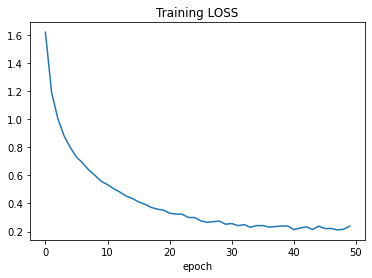

In [47]:
plt.plot(loss_)
plt.title('Training LOSS')
plt.xlabel("epoch")
plt.show()

## 4.모델 저장 및 불러오기 

In [67]:
path = './models/cifar_alexnet.pth'
torch.save(alexnet.state_dict(),path)

In [68]:
alexnet = AlexNet().to(device)
alexnet.load_state_dict(torch.load(path))

<All keys matched successfully>

## 5.평가

In [84]:
correct = 0
total = 0

with torch.no_grad():
    alexnet.eval()
    for data in testloader:
        x,y = data[0].to(device),data[1].to(device)
        y_hat = alexnet(x)
        _,predicted = torch.max(y_hat,1)
        total += y.size(0)
        correct += (predicted == y).sum().item()

print('Test Accuracy: %.3f%%'%(100*correct/total))

Test Accuracy: 75.740%
